In [987]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch import Tensor

from torchvision import transforms, datasets
from torchvision.ops import nms, batched_nms
import torchvision.transforms.functional as fn
import torchmetrics

from torch.utils.data import DataLoader

In [988]:
import wandb
WANDB_LOGGING = False
FREEZE_FEATURE_EXTRACTOR = True
CONFIG = {
    "project_name": "name",
    "dataloader": {
        "batch_size": 32
    },
    "bias": True,
    "lr": 0.0001
}

In [989]:
class DetectionHead(nn.Module):
    def __init__(self, in_channels: int, num_boxes_per_cell: int):
        super().__init__()
        
        out_channels = num_boxes_per_cell * 5
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1)
    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.conv(input)

In [990]:
class CardDetector(nn.Module):
    def __init__(self, num_boxes_per_cell, anchor_box_sizes, anchor_box_aspect_ratios, loss_fn):
        super(CardDetector, self).__init__()

        self.loss_fn = loss_fn
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.num_boxes_per_cell = num_boxes_per_cell
        self.anchor_boxes = self.generate_anchor_boxes(sizes=anchor_box_sizes, aspect_ratios=anchor_box_aspect_ratios)

        print(f"anchor box dimensions: {self.anchor_boxes}")
        
        self.feature_extractor = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])
        if FREEZE_FEATURE_EXTRACTOR:
            for param in self.feature_extractor.parameters():
                param.requires_grad = False
        
        self.detection_head = DetectionHead(in_channels=512, num_boxes_per_cell=self.num_boxes_per_cell)

    def generate_anchor_boxes(self, sizes, aspect_ratios) -> torch.Tensor:
        anchor_boxes = []
        for size in sizes:
            for aspect_ratio in aspect_ratios:
                width = int((size * aspect_ratio) ** 0.5)
                height = int((size / aspect_ratio) ** 0.5)
                anchor_boxes.append((width, height))
        return torch.tensor(anchor_boxes)

    def forward(self, input):
        # Get image width and height
        img_w = input.shape[-2]
        img_h = input.shape[-1]

        # Get feature map
        features = self.feature_extractor(input)

        # Calculate scale factors for width and height
        scale_w = img_w / features.shape[-2]
        scale_h = img_h / features.shape[-1]

        # Get detection vectors for each feature
        detection = self.detection_head(features)
        detection = detection.permute(0,2,3,1).contiguous()
        detection = detection.view(detection.shape[0], detection.shape[1], detection.shape[2], self.num_boxes_per_cell, 5)

        # Apply sigmoid to the first 3 elements of the (p, cx, cy, w, h) tensor
        detection[:, :, :, :, :3] = torch.sigmoid(detection[:, :, :, :, :3])    
        

        anchor_box_scales = self.create_anchor_box_scales(detection_shape=detection.shape)
        anchor_box_offsets = self.create_anchor_box_offsets(detection_shape=detection.shape, scale_w=scale_w, scale_h=scale_h)


        detection[:,:,:,:,3:5] = torch.mul(torch.square(detection[:,:,:,:,3:5]), anchor_box_scales[:,:,:,:,3:5]) # multiply the w, h coords of detection with predifined anchor box w, h
        detection[:,:,:,:,1] = torch.mul(detection[:,:,:,:,1], scale_w)   # scale the x offset from cell orgin
        detection[:,:,:,:,2] = torch.mul(detection[:,:,:,:,2], scale_h)   # scale the y offset from cell origin
        detection[:,:,:,:,1:3] = torch.add(detection[:,:,:,:,1:3], anchor_box_offsets[:,:,:,:,1:3])   # add offset from image origin
        
        print(detection.shape)
        return detection


    def predict(self, input):
        self.eval()

        detection = self.forward(input)
        detection = detection.view(-1, detection.shape[1] * detection.shape[2] * self.num_boxes_per_cell, 5)   # convert the spacial and anchor dimensions into one dimension to get a list of all predictions
        wh_offsets = detection[:, :, 3:5]   # get the predicted width and height
        wh_offsets = torch.mul(wh_offsets, 0.5) # devide the widht and height by two to get the offset from the center

        cx_xy = detection[:, :, 1:3] # get center coordinates

        pred_boxes = detection  
        pred_boxes[:, :, 1:3] = torch.sub(cx_xy, wh_offsets)    # set the first two coordinates to the lower x, lower y by subtracting the offset from the center
        pred_boxes[:, :, 3:5] = torch.add(cx_xy, wh_offsets)    # set the last two coordinates to the greater x, greater y by adding the offset to the center

        # For each image in the input perform Non-max suppression
        #boxes =  pred_boxes[:, :, 1:]   # select the coordinate values
        #objectness_scores = pred_boxes[:, :, :1].squeeze(dim=2) # select the objectness score values, the squeeze to get rid of the extra dimension
#
        #print(f"boxes shape:{boxes.shape}")
        #print(f"objectness scores shape:{objectness_scores.shape}")

        for image in pred_boxes:
            boxes =  image[:, 1:]   # select the coordinate values
            objectness_scores = image[:, :1].squeeze(dim=1) # select the objectness score values, the squeeze to get rid of the extra dimension

            print(f"boxes shape:{boxes.shape}")
            print(f"objectness scores shape:{objectness_scores.shape}")
            indices_to_keep = nms(boxes=boxes, scores=objectness_scores, iou_threshold=0.5)
            kept_boxes = boxes[indices_to_keep[0]]  # TODO: only keeps the highest scoring box - if we have more than one box per image we want to modify this in the future
            print(kept_boxes.shape)

            #TODO: only returns the box for the last image ... maybe we want this method to work for only one image ???
            return kept_boxes.unsqueeze(0)
        
    
    def create_anchor_box_offsets(self, detection_shape, scale_w, scale_h):
        addition_tensor = torch.zeros(detection_shape[0], detection_shape[1], detection_shape[2], detection_shape[3], detection_shape[4])
        for i in range(detection_shape[1]):
            for j in range(detection_shape[2]):
                addition_tensor[:, i, j, :, 1] = i * scale_w
                addition_tensor[:, i, j, :, 2] = j * scale_h      
        return addition_tensor

    def create_anchor_box_scales(self, detection_shape):
        tensor = torch.zeros(detection_shape[0], detection_shape[1], detection_shape[2], detection_shape[3], detection_shape[4])

        for k in range(detection_shape[3]): # num of anchors
            tensor[:, :, :, k, 3] = self.anchor_boxes[k][0]
            tensor[:, :, :, k, 4] = self.anchor_boxes[k][1]
        return tensor

    
    def train_step(self, X, y):
        X, y = X.to(self.device), y.to(self.device)
        y_pred = self(X)
        return self.loss_fn(y_pred, y)
    
    def val_step(self, X, y, accuracy):
        X, y = X.to(self.device), y.to(self.device)
        val_pred = self(X)
        return self.loss_fn(val_pred, y), accuracy(val_pred, y)

In [991]:
input_tensor = torch.randn(2, 3, 224, 224)

model = CardDetector(num_boxes_per_cell=3, anchor_box_sizes=[4096], anchor_box_aspect_ratios=[0.75, 1, 1.25] ,loss_fn=nn.L1Loss(reduction="sum"))
model.eval()

output_tensor = model(input_tensor)

anchor box dimensions: tensor([[55, 73],
        [64, 64],
        [71, 57]])
torch.Size([2, 7, 7, 3, 5])


torch.Size([3, 491, 500])


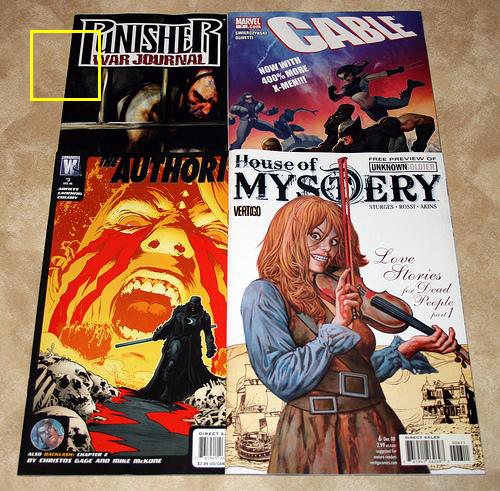

In [992]:
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchvision.ops import box_convert

img_tensor = read_image("data/images/image_01.jpg")

print(img_tensor.shape)

bbox = [[30,30, 100, 100]]
bbox = torch.tensor(bbox, dtype=torch.float)

bbox_img_tensor = draw_bounding_boxes(img_tensor, bbox, width=3, colors=(255,255,0))

fn.to_pil_image(bbox_img_tensor)

In [993]:
CONFIG = {
    "dataset": {
        "img_dir": "data/images/",
        "annotations_file": "data/labels.csv",
    },
    "dataloader": {
        "batch_size": 1,
    }
}

In [994]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

anchor box dimensions: tensor([[ 86, 115],
        [100, 100],
        [111,  89]])


c:\Users\Leonard\anaconda3\envs\pytorch_nn_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Leonard\anaconda3\envs\pytorch_nn_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 16, 16, 3, 5])
boxes shape:torch.Size([768, 4])
objectness scores shape:torch.Size([768])
torch.Size([4])
BOXXXXXXXXXX: tensor([[  39.3061, -136.3882,  102.5466,  144.1777]],
       grad_fn=<UnsqueezeBackward0>)


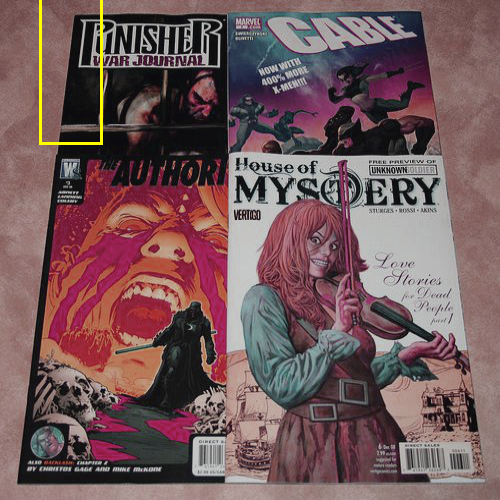

In [995]:
from dataloader_utils import MTGCardsDataset, transform_pipe


test_dataset = MTGCardsDataset(annotations_file=CONFIG["dataset"]["annotations_file"], img_dir=CONFIG["dataset"]["img_dir"], transform=transform_pipe)
test_dataloader = DataLoader(test_dataset, batch_size=1)

images, labels = next(iter(test_dataloader))

model = CardDetector(num_boxes_per_cell=3, anchor_box_sizes=[10000], anchor_box_aspect_ratios=[0.75, 1, 1.25] ,loss_fn=nn.L1Loss(reduction="sum"))

out_tensor = model.predict(images)
print(f"BOXXXXXXXXXX: {out_tensor}")

test_image = fn.convert_image_dtype(image=images.squeeze(0), dtype=torch.uint8)

bbox_img_tensor = draw_bounding_boxes(image=test_image, boxes=out_tensor, width=3, colors=(255,255,0))

fn.to_pil_image(bbox_img_tensor)

In [996]:
from tqdm.auto import tqdm  # We use tqdm to display a simple progress bar, allowing us to observe the learning progression.

def fit(
  model: nn.Module,
  num_epochs: int,
  optimizer: torch.optim.Optimizer,
  train_dataloader: DataLoader,
  val_dataloader: DataLoader,
  device: str,
  print_rate: int = 100
  ):
    # TODO: figure out accuacy
    #accuracy = torchmetrics.Accuracy(task='multiclass', average="weighted").to(model.device)
    accuracy = None
    model = model.to(device=device)
    # Iterate through epochs with tqdm
    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch: {epoch}\n")
        train_loss = 0
        model.train()  # Set mode of model to train
        
        for batch, (X, y) in enumerate(train_dataloader):
            loss = model.train_step(X, y)
            train_loss += loss.item()
            
            # Getting the loss gradient and making an optimizer step
            optimizer.zero_grad()  
            loss.backward()
            optimizer.step()

            if batch % print_rate == 0: 
                print(f"Looked at {batch} Batches\t---\t{batch * len(X)}/{len(train_dataloader.dataset)} Samples")
            elif batch == len(train_dataloader) - 1:
                print(f"Looked at {batch} Batches\t---\t{len(train_dataloader.dataset)}/{len(train_dataloader.dataset)} Samples")
        
        # Divide the train_loss by the number of batches to get the average train_loss
        avg_train_loss = train_loss / len(train_dataloader)

        # Validation
        # Setup the Val Loss and Accuracy to accumulate over the batches in the val dataset
        val_loss = 0
        val_acc = 0
        # Set model to evaluation mode and use torch.inference_mode to remove unnecessary training operations 
        model.eval()
        with torch.inference_mode():
            for X_val, y_val in val_dataloader:
                loss, acc = model.val_step(X_val, y_val, accuracy)
                val_loss += loss.item()
                val_acc += acc

        # Get the average Val Loss and Accuracy
        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_acc = val_acc / len(val_dataloader)

        print(f"Train loss: {avg_train_loss} | Val Loss: {avg_val_loss} | Val Accuracy: {avg_val_acc}")
        if WANDB_LOGGING:
            wandb.log({"Train Loss": avg_train_loss,"Val Loss": avg_val_loss, "Val Accuracy": avg_val_acc})